# Solenoid core

##### How do magnetic field of a solenoid with and without compere?

We will model magnetic field direction and magnetude of a solenoid in vacuum and one with iron core.

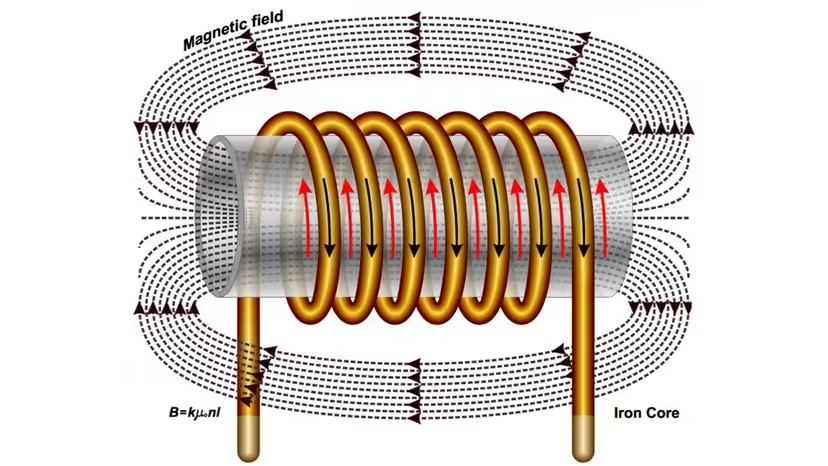

First, we will start with modeling a solenoid. We will assume that the wire is 1 dimensional, and we will simulate the coil, by dividing some points along the wire. We will need 4 initial values: radius, height, wraps and total number of points. Additionaly we will need current through the wire.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

Now we will need to divide the points evenly on the solenoid. Since the spacing between wraps are equal, we know thet all points on the coil fulfils:

$$ \vec{r} = (R cos \theta, R sin \theta, V \theta) $$
$$ \theta \in \mathbb{R} $$

Where R is the radius of the solenoid, and V is a helical constant, such that:
$$ V \theta = z \Rightarrow V = \frac{z}{\theta} \Rightarrow V = \frac{{\Delta z}}{2 \pi} $$
Where $ \Delta z $ is the spacing between two wraps, which equals the total height, divided by number of wraps.

In [3]:
"""
Solenoid constants:
"""
my_0 = 12.57e-7 #H/m

Is = 1 #[A], Current through coil
ns = 500 #[], Solenoid points
Rs = 1 #[m], Solenoid radius
hs = 3 #[m], Solenoid height
ws = 40 #[], Solenoid wraps

n_w = ns//ws #[], Points per wrap
d_theta = 2*np.pi/n_w #[], Rads between points
d_h = hs/ws #[m], Distance between wraps
Vs = d_h/(2*np.pi) #[m], Distance per rad

We will devide points evenly on the solenoid. This means the points will be above each other, and this may thereby not be the best approach, and it will be crucial to have enough points per wrap to get a realistic simulation.

We will too be saving $ \vec{\Delta l} $:
$$ \vec{\Delta l_i} = \vec{r}_{i+1} - \vec{r}_i $$

In [4]:
"""
Creating coil:
"""    
coil = np.zeros((ns,3)) #Points on the coil
coil[0] = np.array([Rs,0,0])
dls = coil.copy()
theta = 0
for i in range(ns-1):
    theta += d_theta
    coil[i+1] = np.array([Rs*np.cos(theta), Rs*np.sin(theta), Vs*theta])
    dls[i] = coil[i+1] - coil[i]

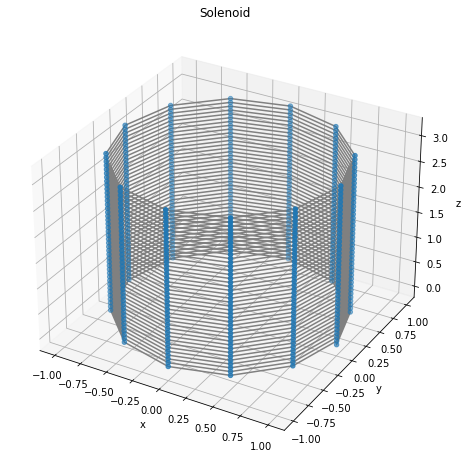

In [5]:
"""
Plotting coil:
"""    
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')
ax.set_title('Solenoid')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.plot3D(coil[:,0], coil[:,1], coil[:,2], 'grey')
ax.scatter3D(coil[:,0], coil[:,1], coil[:,2])
plt.show()

def plot_coil():
    plt.plot([-Rs*1.2, -Rs*1.2],[0.5,2.5], color='r', linewidth=4)
    plt.plot([Rs*1.2, Rs*1.2],[0.5,2.5], color='r', linewidth=4)

Now we need to find the magnetic field in the room. We will use Biot Savart law:

$$ d \vec{B} = \frac{\mu _0}{4 \pi} \frac{I \vec{dl} \times \hat{R}}{|\vec{R}|^2} $$

Thereby the magnetic field in arbitrary point, except on the wire, is:

$$ \vec{B} = \sum_{i=1}^n \frac{\mu _0}{4 \pi} \frac{I \vec{\Delta l_i} \times \hat{R_i}}{|\vec{R_i}|^2} = \sum_{i=1}^n \frac{\mu _0}{4 \pi} \frac{I (x_{i+1}-x_i,y_{i+1}-y_i,z_{i+1}-z_i) \times (x'_i - x_i,y'_i - y_i,z'_i - z_i)}{(x'_i - x_i)^2 + (y'_i - y_i)^2 + (z'_i - z_i)^2}$$

Where n is the number of points on the coil, and $ \vec{R_i} = \vec{r'} - \vec{r_i} $, where $ \vec{r_i} $ is the position of the i-th point on solenoid and $ \vec{r'} $ is the location of the point we are finding magnetic field in.

In [6]:
"""
Magnetic field:
"""
size = hs
if Rs > size:
    size = Rs
size *= 2

resolution = 21 #grid density

line = np.linspace(-size, size, resolution)
line_z = np.linspace(-size+0.5*hs, size+0.5*hs, resolution)
n_loc = len(line)
rx,ry,rz = np.meshgrid(line,line,line_z)

rx2, rz2 = np.meshgrid(line,line_z)

In [7]:
class Solenoid:
    
    def __init__(self, I, title):
        self.title = title
        B = np.zeros((n_loc,n_loc,n_loc), dtype='object')
        for i in range(len(rx.flat)):
            r = np.array([rx.flat[i],ry.flat[i],rz.flat[i]])
            for j in range(len(coil)):
                R = r - coil[j]
                B.flat[i] += my_0/(4*np.pi) * (I*np.cross(dls[j], R))/np.linalg.norm(R)**3
        self.B = B

    def reshape(self):
        x = np.zeros((resolution,resolution, resolution))
        y = np.zeros((resolution,resolution, resolution))
        z = np.zeros((resolution,resolution, resolution))
        B_mag = np.zeros((resolution,resolution, resolution))

        for i in range(len(rx.flat)):
            val_loc = self.B.flat[i]
            x.flat[i] = val_loc[0]
            y.flat[i] = val_loc[1]
            z.flat[i] = val_loc[2]
            B_mag.flat[i] = np.linalg.norm(val_loc)
            self.B_mag = B_mag
        
        self.x = x
        self.y = y
        self.z = z
        self.B_mag = B_mag
    
    def plot_B_3d(self):
        fig = plt.figure(figsize=(8,8))
        ax = fig.add_subplot(projection='3d')
        ax.set_title(f'Magnetic field {self.title}')
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')
        ax.plot3D(coil[:,0], coil[:,1], coil[:,2], 'red')
        ax.quiver(rx, ry, rz, self.x, self.y, self.z, length=2, normalize=True)
        plt.show()
        
    def plot_B_xz(self):
        plt.title(f'B field in xz plane {self.title}')
        plt.axis('equal')
        plt.xlabel('x')
        plt.ylabel('z')
        x2 = self.x[:,resolution//2]
        z2 = self.z[:,resolution//2]
        plt.streamplot(rx2, rz2, x2, z2)
        plot_coil()
        
    def plot_B_mag(self):
        plt.title(f'B field magnetude in xz plane {self.title} [T]')
        plt.xlabel('x')
        plt.ylabel('z')
        self.B_mag2 = self.B_mag[:,resolution//2]
        plt.contourf(rx2, rz2, self.B_mag2)
        plt.colorbar()
        plot_coil()
        
    def plot_B_mag_out(self):
        B_mag3 = self.B_mag2.copy()
        for i in range(len(rx2.flat)):
            if abs(rx2.flat[i]) < Rs*(1.1) and rz2.flat[i] > 0 and rz2.flat[i] < hs:
                B_mag3.flat[i] = 0
            else:
                B_mag3.flat[i] = self.B_mag2.flat[i]
        plt.title(f'B field magnetude in xz plane {self.title} [T]')
        plt.xlabel('x')
        plt.ylabel('z')
        plt.contourf(rx2, rz2, B_mag3)
        plt.colorbar()
        plot_coil()

In [8]:
inst1 = Solenoid(Is, 'vacuum')
B = inst1.B
inst1.reshape()

### Core:

Now we need to find the magnetic field caused by the core. Now we will assume that our core is made from a linear material, such that:

$$ \vec{M} = \chi _m \vec{H} $$

We know that magnetic field strength $ \vec{H} $ is independent of permeability, such that:
$$ \vec{H} = \frac{1}{\mu _0} \vec{B} = \frac{1}{\mu} \vec{B} $$
Therefore the magnetic field strength within the solenoid is independent of the magnetic susceptibility inside it. We have:

$$ \vec{M} = \chi _m \frac{1}{\mu _0} \vec{B} $$

Here we will assume that the core is made from iron with with permeability of $ \, 6.3 \cdot 10^{-3} $ H/m. To find the susceptibility, we know:

$$ \mu = \mu _r \mu _0 = (1+ \chi _m) \mu _0 \\ $$
$$ \chi _m = \frac{\mu}{\mu _0} - 1 \\ \\ $$

Note that we won't include magnetism induced by free charges in core, as since there will be no current through the core, the free charges will in this model be stationary. 

In [9]:
"""
Magnetisation:
"""
my_0 = 12.57e-7 #H/m
my = 6.3e-3 #H/m
chi_m = my/my_0 - 1 #H/m

M = B.copy()

for i in range(len(rx.flat)):
    if np.linalg.norm(np.array([rx.flat[i], ry.flat[i]])) < Rs-0.1 and rz.flat[i] > 0 and rz.flat[i] < hs:
        M.flat[i] = B.flat[i] * chi_m*1/my_0
    else:
        M.flat[i] = np.ones(3)*1e-3

Mx = np.zeros((resolution,resolution, resolution))
My = np.zeros((resolution,resolution, resolution))
Mz = np.zeros((resolution,resolution, resolution))

for i in range(len(rx.flat)):
    val_loc = M.flat[i]
    Mx.flat[i] = val_loc[0]
    My.flat[i] = val_loc[1]
    Mz.flat[i] = val_loc[2]

Mx2 = Mx[:,resolution//2]
Mz2 = Mz[:,resolution//2]

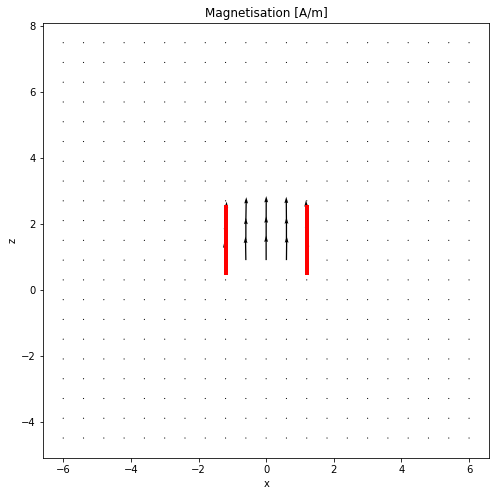

In [10]:
"""
Plot magnetisation:
"""
plt.figure(figsize=(8,8))
plt.title('Magnetisation [A/m]')
plt.xlabel('x')
plt.ylabel('z')
plt.quiver(rx2, rz2, Mx2, Mz2, scale=1e6)
plot_coil()
plt.show()

Here we see that the magnetisation is relativly stable through the core and almost parallel with the z-axis, we will therefore assume that it is homogeneous and parallel with z.

Now we use the definition of current density of bounded charges.

$$ \nabla \times \vec{M} = \vec{J_b} $$

Since we know that the core will have relatively stable magnetisation in it and zero magnetisation outside of it, will there be a finite drop in magnetisation over a infinitesimal length. This means that by definition of curl, will the current density on the surface be infinite.

Fortunately we are not necessarily interested in current density, as the current will be satisfactory. We have:

$$ \iint _s \nabla \times \vec{M} \cdot \vec{dS} = \iint _s \vec{J_b} \cdot \vec{dS} = I_b $$

Which by the Stoke's theorem gives:

$$ \oint _c \vec{M} \cdot \vec{dl} = I_b $$

Where I_b is the current through the surface s. Since we are interested in surface current through in the whole core, we can define s as a rectangle with two sides in a constant radius, such as one of the side is inside the core, and the second outside, and they contain the whole core. The other two sides will be parallel with radial direction. In that case, we have:

$$ \oint _c \vec{M} \cdot \vec{dl} = In_1 + In_2 + In_3 + In_4 $$

Since the magnetism is homogeneous, all the $ In_i $ except the one side that is completly inside the core will be zero. The one  except side will becouse of our assumptions be:

$$ \oint _c \vec{M} \cdot \vec{dl} = |\vec{M}|h $$

Where h is the height of the core. 

$$ \Rightarrow \: I_b = |\vec{M}|h \\ \\ \\ $$

Now we wish to simulate the magnetic field of the soilenoid with and without the core. To simulate the magnetic field from the core as accurately as possible, we would need to create a object, with as many rings as possible, with as many points on each rings as possible, where we would imagine each point as a charge carrier. 

Althought not difficult, since we already possess code for creating solenoid we will insted simulate the core as a solenoid. This should be a good approximation if the solenoid has enough wraps, because if we imagine a solenid with infinite wraps, the non angular velocity component of each charge carrier will be zero. Furthermore, since we already have a solenoid in correct position, insted of modeling another one, we can just increase the current adequate.

Since we only have current through the whole surface, we see that in order to simulate the core correctly, we need to maintan this condition. Thereby the current increasement current throug the same rectangle will need to be equal to $ I_b $.

$$ \iint_s \vec{J} _b \cdot \vec{dS} = \iint_s \vec{J} _s \cdot \vec{dS} = NI $$

Where N in the number of wraps, and I is the current through the wire.

In [11]:
"""
Current:
"""
Ib = np.max(Mz2)*hs
Ib /= ws
I_tot = Is + Ib

In [12]:
"""
Simulation:
"""
inst2 = Solenoid(I_tot, 'core')
inst2.reshape()

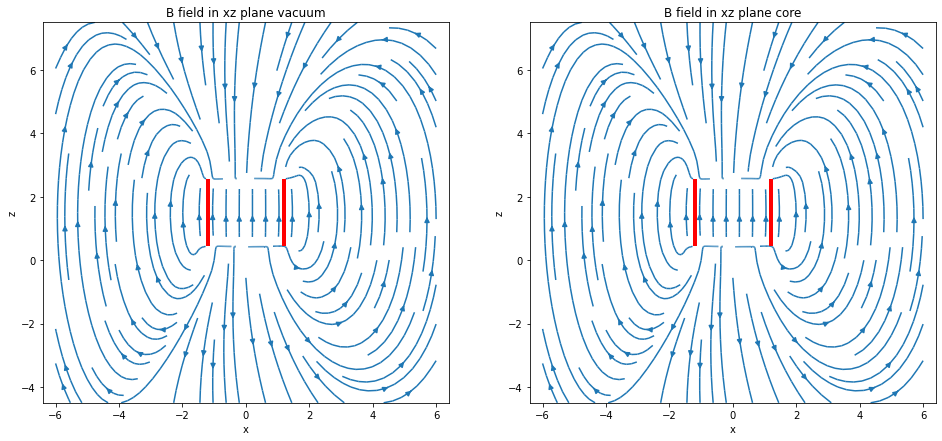

In [13]:
plt.figure(figsize=(16,7))
plt.subplot(1,2,1)
inst1.plot_B_xz()
plt.subplot(1,2,2)
inst2.plot_B_xz()
plt.show()

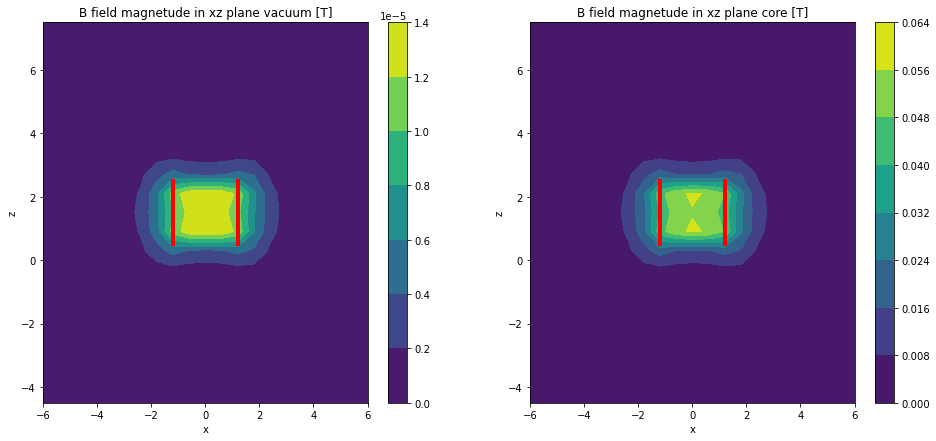

In [14]:
plt.figure(figsize=(16,7))
plt.subplot(1,2,1)
inst1.plot_B_mag()
plt.subplot(1,2,2)
inst2.plot_B_mag()
plt.show()

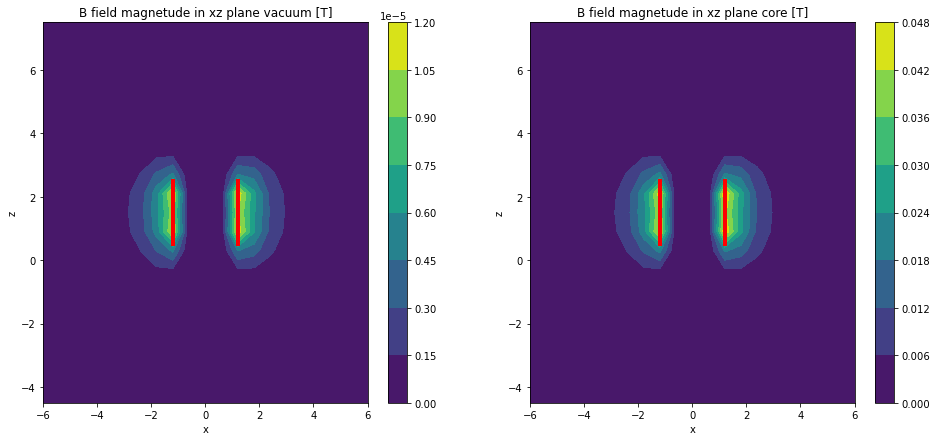

In [15]:
plt.figure(figsize=(16,7))
plt.subplot(1,2,1)
inst1.plot_B_mag_out()
plt.subplot(1,2,2)
inst2.plot_B_mag_out()
plt.show()

In [17]:
Bm1 = inst1.B_mag
Bm2 = inst2.B_mag

print(f'The core solenoid to vacuum solenoid magnetude: {np.max(Bm2)/np.max(Bm1):.0f}')
print(f'The magnetic susceptibility: {chi_m:23.0f}')

The core solenoid to vacuum solenoid magnetude: 4126
The magnetic susceptibility:                    5011


Here we see that magnetic field magnetude is approximatly equal the susceptibility constant.   

As we see, in our model, the core dosn't have an effect on the magnetic field shape. This is obvius, as we do model the surface currents in the core, as an increasment in current through the coil, but because of reasons stated above, this is a realistic model. We can thereby conclude, that as long as the core is the exact size of the solenoid, the magnetic field direction stays unchanged. 

On the other hand, we have observed a drastical change in magnetude of the magnetic field for the solenoid with iron core. This increasment was aproximatly on the level of the magnetic susceptibility of the material forming the core. We have not confirmed this effect as we did not calculate the values for different scenarios, for eksample, different initial values of the solenoid or different core materials, but this effect can be shown to be true analytically.